In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, CuDNNLSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score

Using TensorFlow backend.
/Users/dylanhhampton/anaconda2/envs/EEGModelEnv1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/dylanhhampton/anaconda2/envs/EEGModelEnv1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/dylanhhampton/anaconda2/envs/EEGModelEnv1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

In [2]:
import os
print(os.listdir("input"))

['testData', '.DS_Store', 'test', '.sample_submission.csv.icloud', 'train']


In [17]:
# -*- coding: utf-8 -*-
"""

@author Ajoo
forked from Adam Gągol's script based on Elena Cuoco's

"""

import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from sklearn.linear_model import LogisticRegression
#from sklearn.lda import LDA
#from sklearn.qda import QDA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


#############function to read data###########
FNAME = "input/{0}/subj{1}_series{2}_{3}.csv"
def load_data(subj, series=range(1,9), prefix = 'train'):
    data = [pd.read_csv(FNAME.format(prefix,subject,s,'data'), index_col=0) for s in series]
    idx = [d.index for d in data]
    data = [d.values.astype(float) for d in data]
    if prefix == 'train':
        events = [pd.read_csv(FNAME.format(prefix,subject,s,'events'), index_col=0).values for s in series]
        return data, events
    else:
        return data, idx

def compute_features(X, scale=None):
    X0 = [x[:,0] for x in X]
    X = np.concatenate(X, axis=0)
    F = [];
    for fc in np.linspace(0,1,11)[1:]:
        b,a = butter(3,fc/250.0,btype='lowpass')
        F.append(np.concatenate([lfilter(b,a,x0) for x0 in X0], axis=0)[:,np.newaxis])
    F = np.concatenate(F, axis=1)
    F = np.concatenate((X,F,F**2), axis=1)
        
    if scale is None:    
        scale = StandardScaler()
        F = scale.fit_transform(F)
        return F, scale
    else:
        F = scale.transform(F)
        return F


#%%########### Initialize ####################################################
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

subjects = range(1,13)
idx_tot = []
scores_tot = []



In [56]:
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:

    X_train, y = load_data(subject)
    X_test, idx = load_data(subject,[9,10],'test')



################ Train classifiers ###########################################
    lda = LDA()
    rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion="entropy", random_state=1)
    lr = LogisticRegression()
    
    X_train, scaler = compute_features(X_train)
    X_test = compute_features(X_test, scaler)   #pass the learned mean and std to normalized test data
    
    y = np.concatenate(y,axis=0)
    scores = np.empty((X_test.shape[0],6))
    
    downsample = 35
    for i in range(6):
        print('Train subject %d, class %s' % (subject, cols[i]))
        rf.fit(X_train[::downsample,:], y[::downsample,i])
        lda.fit(X_train[::downsample,:], y[::downsample,i])
        lr.fit(X_train[::downsample,:], y[::downsample,i])
       
        scores[:,i] = ((rf.predict_proba(X_test)[:,1]**0.85)*0.33 + 
                        (lda.predict_proba(X_test)[:,1]**0.95)*0.34 + 
                        (lr.predict_proba(X_test)[:,1]**0.85)*0.33)

    scores_tot.append(scores)
    idx_tot.append(np.concatenate(idx))
    
#%%########### submission file ################################################
submission_file = 'Submission.csv'
# create pandas object for submission
submission = pd.DataFrame(index=np.concatenate(idx_tot),
                          columns=cols,
                          data=np.concatenate(scores_tot))

# write file
submission.to_csv(submission_file,index_label='id',float_format='%.3f')

FileNotFoundError: [Errno 2] File b'input/train/subj1_series1_data.csv' does not exist: b'input/train/subj1_series1_data.csv'

In [7]:
import numpy as np

import pandas as pd
import math as m
from sklearn import preprocessing


subjects = range(1, 2)
train_series = range(1, 2)
test_series = range(9, 10)

for subject in subjects:
    fname = ("input/train/subj%d_series1_data.csv" % (subject))
    train = pd.read_csv(fname)
    
    fname = ("input/train/subj%d_series1_events.csv" % (subject))
    labels = pd.read_csv(fname)
    
    train = pd.merge(train, labels, on = 'id')
    
    idx = train.id.values
    
    train = train.drop(['id'], axis = 1)
    columns = train.columns[ :-6 ]
    
    x_train = train[ :, :-6 ]
    y_train = train[ :, 32: ]
    
    colcount = x_train.shape[1]
    rowcount = x_train.shape[0]
    
    for i in range(0, colcount):
        x_train[:, i] = preprocessing.scale(x_train[:, i])
        mean = np.mean(x_train[:, i])
        max = np.max(x_train[:, i])
        min = np.min(x_train[:, i])
        for j in rnage(0, rowcount):
            x_train[j, i] = (x_train[j,i] - min)/( max - min)
            
    x_train = np.array(x_train).astype(float)
    y_train = np.array(y_train).astype(float)
    
    
    

TypeError: '(slice(None, None, None), slice(None, -6, None))' is an invalid key

In [6]:
import numpy as np
load = 1
time_steps = 1000
subsample = 100
x_paths = ["train/subj1_series1_data.csv", "train/subj1_series2_data.csv", "train/subj1_series3_data.csv", "train/subj1_series4_data.csv", \
          "train/subj2_series1_data.csv", "train/subj2_series2_data.csv", "train/subj2_series3_data.csv", "train/subj2_series4_data.csv", \
          "train/subj3_series1_data.csv", "train/subj3_series2_data.csv", "train/subj3_series3_data.csv", "train/subj3_series4_data.csv", \
          "train/subj4_series1_data.csv", "train/subj4_series2_data.csv", "train/subj4_series3_data.csv", "train/subj4_series4_data.csv",\
          "train/subj5_series1_data.csv", "train/subj5_series2_data.csv", "train/subj5_series3_data.csv", "train/subj5_series4_data.csv",\
          "train/subj6_series1_data.csv", "train/subj6_series2_data.csv", "train/subj6_series3_data.csv", "train/subj6_series4_data.csv"]
y_paths = ["train/subj1_series1_events.csv", "train/subj1_series2_events.csv", "train/subj1_series3_events.csv", "train/subj1_series4_events.csv", \
          "train/subj2_series1_events.csv", "train/subj2_series2_events.csv", "train/subj2_series3_events.csv", "train/subj2_series4_events.csv", \
          "train/subj3_series1_events.csv", "train/subj3_series2_events.csv", "train/subj3_series3_events.csv", "train/subj3_series4_events.csv", \
          "train/subj4_series1_events.csv", "train/subj4_series2_events.csv", "train/subj4_series3_events.csv", "train/subj4_series4_events.csv", \
          "train/subj5_series1_events.csv", "train/subj5_series2_events.csv", "train/subj5_series3_events.csv", "train/subj5_series4_events.csv", \
          "train/subj6_series1_events.csv", "train/subj6_series2_events.csv", "train/subj6_series3_events.csv", "train/subj6_series4_events.csv"]

if load:
    x_data = []
    for x_path in x_paths:
        x_path = "input/" + x_path
        print("X Path: ", x_path)
        with open(x_path) as file:
            for line in file:
                if line[0] == "i": continue
                line_array = []
                for word in range(len(line.split(','))-1):
                    word+=1
                    line_array.append(int(line.split(',')[word]))
                line_array = np.asarray(line_array)
                x_data.append(line_array)
    x_data = np.asarray(x_data)    
        
  
    y_data = []
    for y_path in y_paths:
        y_path = "input/" + y_path
        print("Y Path: ", y_path)
        with open(y_path) as file:
            for line in file:
                if line[0] == "i": continue
                line_array = []
                for word in range(len(line.split(','))-1):
                    word+=1
                    line_array.append(int(line.split(',')[word]))
                line_array = np.asarray(line_array)
                y_data.append(line_array)
    y_data = np.asarray(y_data)

print(x_data)

X Path:  input/train/subj1_series1_data.csv


KeyboardInterrupt: 

In [4]:
print(x_data.shape)
top_model_weights_path = 'bottleneck_fc_model.h5'

(4850019, 32)


In [5]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

x_val_path = "input/train/subj4_series7_data.csv"
y_val_path = "input/train/subj4_series7_events.csv"
x_val_data = []
with open(x_val_path) as file:
    for line in file:
        if line[0] == "i": continue
        line_array = []
        for word in range(len(line.split(','))-1):
            word+=1
            line_array.append(int(line.split(',')[word]))
        line_array = np.asarray(line_array)
        x_val_data.append(line_array)
x_val_data = np.asarray(x_val_data)    
        
  
y_val_data = []
with open(y_val_path) as file:
    for line in file:
        if line[0] == "i": continue
        line_array = []
        for word in range(len(line.split(','))-1):
            word+=1
            line_array.append(int(line.split(',')[word]))
        line_array = np.asarray(line_array)
        y_val_data.append(line_array)
y_val_data = np.asarray(y_val_data)  


def train_generator(batch_size):
    while 1:
        
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        y_label_data = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(x_data)-time_steps)
            x_time_data[i] = x_data[random_index:random_index+time_steps:subsample]
            y_label_data.append(y_data[random_index + time_steps])
        y_label_data = np.asarray(y_label_data)

        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), y_label_data


def val_generator():
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(x_val_data)-time_steps)
            x_time_data[i] = x_val_data[random_index:random_index+time_steps:subsample]
            yy.append(y_val_data[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), yy
        

def roc_generator():
    batch_size = 1
    x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
    yy = []
    for i in range(batch_size):
        random_index = np.random.randint(0, len(x_val_data)-time_steps)
        x_time_data[i] = x_val_data[random_index:random_index+time_steps:subsample]
        yy.append(y_val_data[random_index + time_steps])
    yy = np.asarray(yy)
    return x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), yy



In [21]:
# Creating the CNN Model


model = Sequential()
#model.add(CuDNNLSTM(128, input_shape = (time_steps//subsample, 32)))
model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape = (time_steps//subsample, 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu", input_shape = (time_steps//subsample, 32, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (time_steps//subsample, 32, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation = "sigmoid"))


adam = Adam(lr = 0.001)

model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 32, 64)        3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 32, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 10, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [54]:
#X_train = np.asarray(X_train)
#print(X_train)

#np.reshape(X_train,32,32)
X_train = X_train.reshape((X_train.shape[0], 1))
#print(X_train.shape)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
#y.shape()

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_train = X_train.reshape(-1,32, 32, 1)  

(8, 1, 1)
(8, 1, 1, 1)


ValueError: cannot reshape array of size 8 into shape (32,32,1)

In [45]:



history = model.fit(X_train, y, steps_per_epoch = 5000, epochs = 10)


# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(top_model_weights_path)
print("Saved model to disk")
#print("saving")
#submission_name = "basic-cnn-model.csv"            

#submission = pd.DataFrame(columns=labelNames, data=np.concatenate(results), index=np.concatenate(results_ids))
#submission.to_csv(submission_name,index_label="id",float_format='%.3f')






ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (8, 1, 1)

In [24]:
history = model.fit_generator(train_generator(32), steps_per_epoch = 5000, epochs = 10, validation_data=val_generator(), validation_steps=32)


# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(top_model_weights_path)
print("Saved model to disk")
#print("saving")
#submission_name = "basic-cnn-model.csv"            

#submission = pd.DataFrame(columns=labelNames, data=np.concatenate(results), index=np.concatenate(results_ids))
#submission.to_csv(submission_name,index_label="id",float_format='%.3f')





ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 8 arrays: [array([[-542.,  114., -263., ..., -243., -215.,  -61.],
       [-570.,   80., -285., ..., -200., -191.,    1.],
       [-635.,   44., -325., ..., -209., -189.,   25.],
       ...,
       [ 131.,  205...

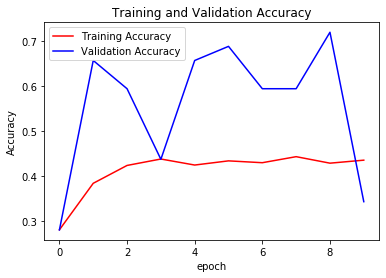

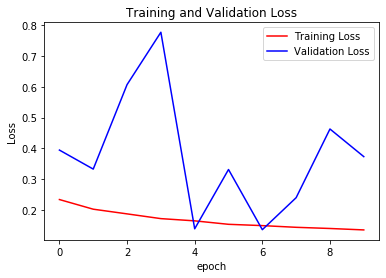

In [9]:
#from keras.utils import plot_model
#plot_model(model, to_file="model.png")
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()




In [64]:
gen_data = val_generator()
scores = []
num_test = 100
#testAccuracy = []
#testActual = []
actualLabel = []
predictedLabel = []

#for i in range(num_test):
    #x_test, y_test = next(gen_data)
    
    #(eval_loss, eval_accuracy) = model.evaluate(x_test, y_test, steps=50)
    #print("[INFO] Evaluated Accuracy: {:.2f}%".format(eval_accuracy * 100))
    #print("[INFO] Evaluated Loss: {}%".format(eval_loss))
    #print("\n")
    
    #pred1 = model.evaluate(x_test, y_test, steps=50)
    #print("[INFO]  Accuracy: ", str(pred1))
    #print("[INFO]  Loss: ", str(pred1))
    #print("\n")
    
    
    
label_names=['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']

for i in range(num_test):
    x_test, y_test = next(gen_data)
    
    while not 1 in y_test:
        
        #print(y_test)
        x_test, y_test = next(gen_data)
        
        # print(y_test)
        y_out = model.predict(x_test).reshape((6,1))
        # print(y_out)
    #testAccuracy.append(y_out)
    #testActual.append(y_test)
    
    predictedLabel.append(y_out)
    actualLabel.append(y_test)

    scores.append(roc_auc_score(y_test.reshape((6,1)), y_out))
    
predictedLabel = np.asarray(predictedLabel)
#print(predictedLabel)
#testAccuracy = np.arange(testAccuracy)
#testAccuracy = np.ndarray.reshape((6,1), order='C')

actualLabel = np.asfarray(actualLabel)

#print("actualLabel type: " , type(actualLabel))
#print(actualLabel.shape)
#testActual = list(testActual)
#print("\n[INFO] ROC AUC SCefwefwORES: ", actualLabel)   

predictedLabel = np.round(predictedLabel)
predictedLabel = np.asfarray(predictedLabel)
predictedLabel.resize(num_test,1,6)
predictedLabel = predictedLabel


scores = np.asarray(scores)




#print("type testAccuracy: ", type(predictedLabel))
#print("Predicted Label: ", predictedLabel)
#print("Actual Label: ", actualLabel)



#print("\n[INFO] ROC AUC SCORES: ", scores)
print("\n[INFO] ROC AUC SCORE Mean: ", np.mean(scores))


#print("\n[INFO] Prediction Accuracy Scores: ", testAccuracy)
print("\n[INFO] Prediction Accuracy Mean: ", np.mean(predictedLabel))


#print("\n[INFO] Prediction Accuracy Scores: \n", predictedLabel)
#avgScores = scores
#avgTestAccuracy = testAccuracy



[INFO] ROC AUC SCORE Mean:  0.7278888888888888

[INFO] Prediction Accuracy Mean:  0.058333333333333334


In [34]:
i = 0
correctPredictions = 0
incorrectPredictions = 0


while i < len(actualLabel):
    
    if np.array_equal(actualLabel[i], predictedLabel[i]):
        #print("Prediction Correct")
        correctPredictions += 1
    else:
        incorrectPredictions += 1
        #print("Prediction Wrong")
    i = i+1
    
    
print("Correctly Predicted: ", correctPredictions)
print("incorrectly Predicted: ",incorrectPredictions)


#print("done")
#print(scores) 

Correctly Predicted:  23
incorrectly Predicted:  77


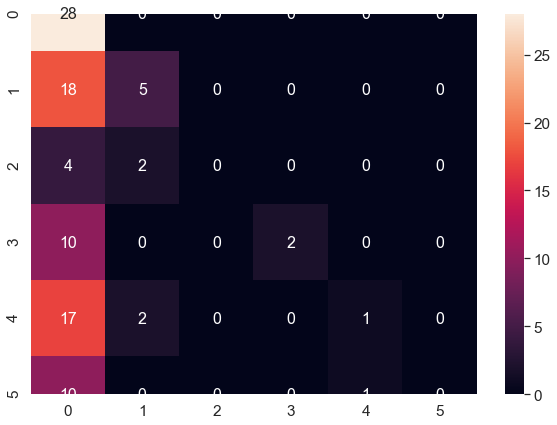

In [24]:
#from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn

y_test_non_category = [ np.argmax(t) for t in actualLabel ]
y_predict_non_category = [ np.argmax(t) for t in predictedLabel ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)


plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

#cm = confusion_matrix(actualLabel, predictedLabel)

In [61]:
import numpy as np
import matplotlib.pyplot as plt


def pdf(x, std, mean):
    cons = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = cons*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist

x = np.linspace(0, 1, num=100)
good_pdf = pdf(x,0.1,0.4)
bad_pdf = pdf(x,0.1,0.6)

#good_pdf = correctPredictions
#bad_pdf = pdf(x,0.1,0.6)

def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])
    


In [69]:
def plot_roc(good_pdf, bad_pdf, ax):
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/100
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])
    

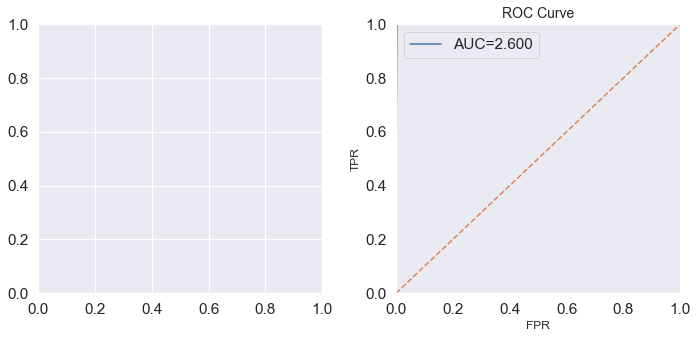

In [70]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
#plot_pdf(good_pdf, bad_pdf, ax[0])
plot_roc(good_pdf, bad_pdf, ax[1])
plt.tight_layout()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i][0], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
    
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i][0]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
  
    plt.ylim([0, 1]) 
  
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
import random
from random import randint

i = 0


while i < len(actualLabel):
    
    #if np.array_equal(actualLabel[i], predictedLabel[i]):
    #    print("Prediction Correct")
    #    plt.plot(actualLabel[i], predictedLabel[i])
    #    plt.show()
    #else:
    #    print("Prediction Wrong")
    #i = i+1
    
    predictedLabel, actualLabel = predictedLabel[i], actualLabel[i][0]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(6), predictedLabel, color="#777777")

    plt.ylim([0, 1]) 

    predictedLabel = np.argmax(predictedLabel)

    thisplot[predictedLabel].set_color('red')
    thisplot[actualLabel].set_color('blue')

#for i in range (0, 20):
    #j = randint(1, 999)
    #plt.figure(figsize=(6,3))
    #plt.subplot(1,2,1)
    #plot_image(j, predictedLabel, actualLabel-1)
    #plt.plot(1,2,2)
    #plot_value_array(i, predictedLabel,  actualLabel-1)

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
x_test, y_test = next(gen_data)

x_test.shape()
y_test.shape()

x_test.reshape(6,1)
y_test.reshape(6,1)

probs = model.predict(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test.values.argmax(axis=1), preds.argmax(axis=1))

roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [ ]:
preds = np.round(model.predict_generator(val_generator(), steps=5))
print("Predicted Labels: \n", preds)

plt.plot(preds)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

preds = np.round(model.predict_generator(val_generator(), steps=1))
print("Predicted Labels: \n", preds)
preds = np.argmax(preds, axis=1)

y_test = next(gen_data)

print('Confusion Matrix')
print(confusion_matrix(y_test, preds))

print('Classification Report')
target_names=['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

events=['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']
classification_metrics = metrics.classification_report(test_labels)

In [ ]:
# Calculate Area under the curve to display on the plot
auc = scores
# Now, plot the computed values
plt.plot(label='%s ROC (area = %0.2f)' % (model['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [ ]:
from sklearn.metrics import confusion_matrix

class_names= ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    
np.set_printoptions(precision=2)

#Plot non-normalised confusion matrix
y_pred = model.predict(x_test)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred)
#y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)

#plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion Matrix')


In [ ]:
y_true.shape

In [ ]:
y_pred.shape

In [ ]:
x_test.shape

In [ ]:
y_test.shape